In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tfK = tf.keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.optimizers import Adam

In [2]:
from tensorflow.python.client import device_lib

# device_lib.list_local_devices()
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
data_array = np.load("rcnn-data-array.npy")
label_array = np.load("rcnn-label-array.npy")

print(data_array.shape)
print(label_array.shape)
print(np.sum(label_array))
print()

label_array = np.expand_dims(label_array, axis=2)

print(data_array.shape)
print(label_array.shape)

(2418, 24, 8192)
(2418, 24)
11231

(2418, 24, 8192)
(2418, 24, 1)


In [4]:
np.average(label_array)

0.1935311552247036

In [5]:
slices_per_patient = 24
model_metrics = ["accuracy", tfK.metrics.Precision(), tfK.metrics.Recall(), tfK.metrics.AUC()]
# model_metrics = [tfK.metrics.Recall()]
# model_metrics = ["accuracy"]
batch_size = 100
epochs=100
model_name = "model16-lr0.0001-2xdropout0.5-bnorm-lstm128-dense100"

stopping = EarlyStopping("val_recall", patience=20, verbose=2, mode="max")
checkpoint = ModelCheckpoint("RNN_models/bi-rcnn-model16-lr0.0001-2xdropout0.5-bnorm-lstm128-dense100-{epoch:03d}-{val_recall:.2f}.hdf5", 
# checkpoint = ModelCheckpoint("bi-rcnn-model.hdf5", 
                             "val_accuracy",
                             save_best_only=False, verbose=2)
callbacks = [stopping, checkpoint]

# class_weight = {0:0.15,
#                 1:0.85}

In [6]:
# with tf.device("/CPU:0"):
with tf.device("/GPU:1"):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(slices_per_patient, 8192)))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(Dense(100, use_bias=False)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation("relu")))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(Dense(100, use_bias=False)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation("relu")))
    model.add(TimeDistributed(Dense(1, activation="sigmoid")))
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.0001), metrics=model_metrics)

In [7]:
history = model.fit(data_array, label_array,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=callbacks,
                    verbose=2)

Train on 1934 samples, validate on 484 samples
Epoch 1/100

Epoch 00001: saving model to RNN_models/bi-rcnn-model16-lr0.0001-2xdropout0.5-bnorm-lstm128-dense100-001-0.94.hdf5
1934/1934 - 19s - loss: 0.9030 - accuracy: 0.4424 - precision: 0.2292 - recall: 0.8052 - auc: 0.6518 - val_loss: 0.7094 - val_accuracy: 0.5745 - val_precision: 0.3114 - val_recall: 0.9378 - val_auc: 0.8552
Epoch 2/100

Epoch 00002: saving model to RNN_models/bi-rcnn-model16-lr0.0001-2xdropout0.5-bnorm-lstm128-dense100-002-0.88.hdf5
1934/1934 - 8s - loss: 0.8049 - accuracy: 0.5656 - precision: 0.2854 - recall: 0.8390 - auc: 0.7598 - val_loss: 0.6381 - val_accuracy: 0.7218 - val_precision: 0.4080 - val_recall: 0.8786 - val_auc: 0.8672
Epoch 3/100

Epoch 00003: saving model to RNN_models/bi-rcnn-model16-lr0.0001-2xdropout0.5-bnorm-lstm128-dense100-003-0.80.hdf5
1934/1934 - 10s - loss: 0.7426 - accuracy: 0.6274 - precision: 0.3172 - recall: 0.8152 - auc: 0.7818 - val_loss: 0.5886 - val_accuracy: 0.7951 - val_precision

In [8]:
with open("RNN_histories/bi-rcnn-{}.pkl".format(model_name), "wb") as f:
    pickle.dump(history.history, f)

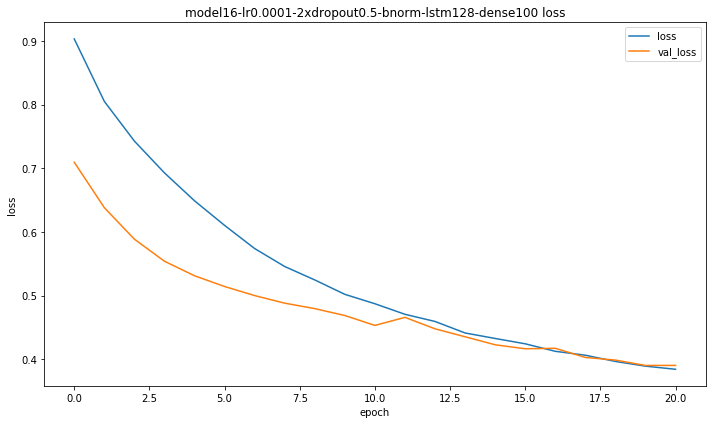

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("{} loss".format(model_name))
plt.legend()
plt.tight_layout()
plt.savefig("RNN_plots/bi-rcnn-{}_loss.png".format(model_name), dpi=300)
plt.show()

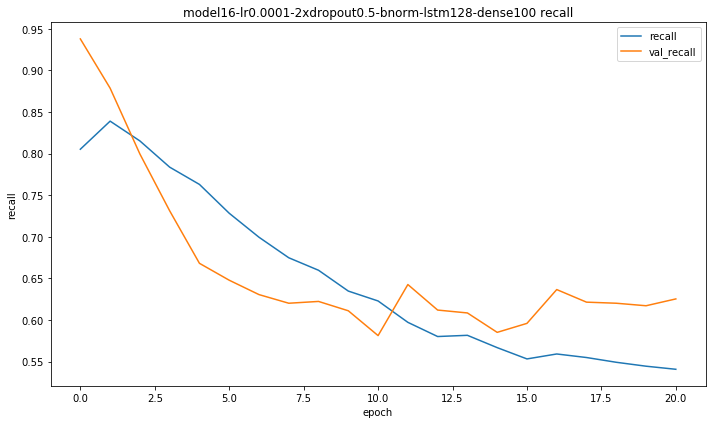

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["recall"], label="recall")
plt.plot(history.history["val_recall"], label="val_recall")
plt.xlabel("epoch")
plt.ylabel("recall")
plt.title("{} recall".format(model_name))
plt.legend()
plt.tight_layout()
plt.savefig("RNN_plots/bi-rcnn-{}_recall.png".format(model_name), dpi=300)
plt.show()

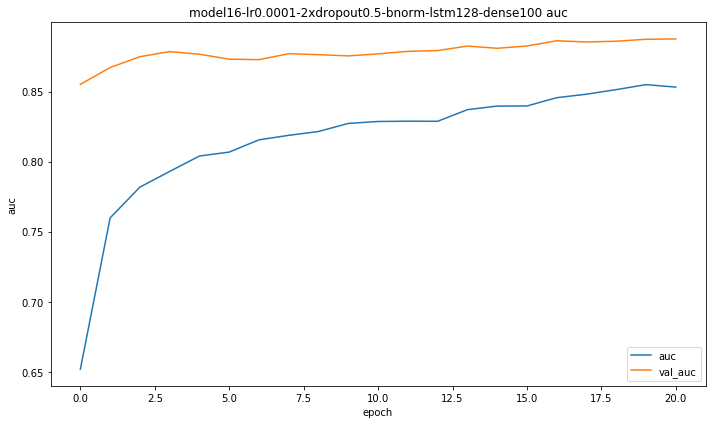

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["auc"], label="auc")
plt.plot(history.history["val_auc"], label="val_auc")
plt.xlabel("epoch")
plt.ylabel("auc")
plt.title("{} auc".format(model_name))
plt.legend()
plt.tight_layout()
plt.savefig("RNN_plots/bi-rcnn-{}_auc.png".format(model_name), dpi=300)
plt.show()